In [1]:
using Random, Distributions
using CSV
using DataFrames
using StatsBase
using CairoMakie

include("../src/SpectralStatistics.jl")
import .SpectralStatistics as ss

In [2]:
function load_unfolded_spectrum(data_folder, typ, kind; n0 = 0, n1 = 2000000 )
    filename = "/unfolded_spectrum_triangle_$(typ)_$(kind)_n_$(n0)_to_$(n1).csv"
    df = DataFrame(CSV.File(data_folder * filename, header=0) )
    e = df.Column1
    spect = ss.UnfoldedSpectrum(e)
end

function load_kspectrum(data_folder, typ, kind; n0 = 0, n1 = 2000000 )
    filename = "/kspectrum_triangle_$(typ)_$(kind)_n_$(n0)_to_$(n1).csv"
    df = DataFrame(CSV.File(data_folder * filename, header=0) )
    k = df.Column1
    spect = ss.WavenumberSpectrum(k)
end

load_kspectrum (generic function with 1 method)

In [3]:
data_folder = "/media/crt/Linux/Programs/QuantumBilliards/TrianglesBogomolny/Analysis/Data/Spectra"

typ = "B"
kind = 1

spect = load_unfolded_spectrum(data_folder, typ, kind; n0 = 0, n1 = 2000000 )
kspect = load_kspectrum(data_folder, typ, kind; n0 = 0, n1 = 2000000 )

range = 10001 : 2000000
ks = kspect.data[range]
e, fluct = ss.mode_fluctuations(spect.data[range])

rho_fluct = fluct .+ range[1]

1990000-element Vector{Float64}:
   2.6530269533814135
   3.075956176619002
   3.5598639501840807
   3.617001169342984
   2.86789807464811
   1.1377829493849276
   1.0168676467055775
   0.15642732394917402
   0.3349090764186258
   1.252298047664226
   1.2464214973333583
   1.8440950445256021
   1.246274580120371
   ⋮
 -17.173368686577305
 -17.647090260172263
 -17.404089563293383
 -17.259617355186492
 -16.895867753075436
 -16.406509856460616
 -15.831473974511027
 -15.711778596509248
 -16.109650612343103
 -16.31240407167934
 -16.55697540473193
 -15.9952504967805

In [15]:
@inline function length_spectrum(l::Float64, rho_fluct::Vector{Float64}, ks::Vector{Float64})
    l_spec = complex(0.0)
    for (rho, k)  in zip(rho_fluct, ks) 
        l_spec += rho * exp(im * k * l)
    end
    norm = length(rho_fluct)
    return abs(l_spec)/norm
end


function length_spectrum(rho_fluct::Vector{Float64}, ks::Vector{Float64}; min = 0.0, max =5.0, grid = 200)
    ls = collect(LinRange(min,max, grid))
    l_spec = zeros(grid) 
    Threads.@threads for i in 1:grid
        l_spec[i] = length_spectrum(ls[i],rho_fluct,ks)        
    end
    return ls, l_spec
end

length_spectrum (generic function with 2 methods)

In [19]:
ls, l_spec = ss.length_spectrum(rho_fluct, ks, min = 0.01, max =50.0, grid = 1000)

([0.01, 0.06004004004004004, 0.11008008008008008, 0.1601201201201201, 0.21016016016016015, 0.26020020020020024, 0.3102402402402402, 0.36028028028028025, 0.4103203203203203, 0.4603603603603604  …  49.549639639639636, 49.59967967967968, 49.64971971971973, 49.69975975975976, 49.7497997997998, 49.79983983983984, 49.84987987987988, 49.89991991991992, 49.94995995995996, 50.0], [0.20629417677274248, 0.045385874175623064, 0.020957801831276456, 0.01577186211333267, 0.01012683109136015, 0.009526504585945674, 0.008175572497290309, 0.0054495206279973575, 0.005201859297501668, 0.004318107748696143  …  0.002237324921144346, 0.001423203765009024, 0.0002475231860643716, 0.0016248540253849012, 0.002785180816599618, 0.0009415430545948552, 0.00044356661226352677, 0.0008825929387594607, 0.0005480344711797948, 0.0067549103417134495])

In [4]:
using Profile

@profile ss.length_spectrum(rho_fluct, ks, min = 0.01, max =50.0, grid = 1000)

([0.01, 0.06004004004004004, 0.11008008008008008, 0.1601201201201201, 0.21016016016016015, 0.26020020020020024, 0.3102402402402402, 0.36028028028028025, 0.4103203203203203, 0.4603603603603604  …  49.549639639639636, 49.59967967967968, 49.64971971971973, 49.69975975975976, 49.7497997997998, 49.79983983983984, 49.84987987987988, 49.89991991991992, 49.94995995995996, 50.0], [0.20629417677274248, 0.045385874175623064, 0.020957801831276456, 0.01577186211333267, 0.01012683109136015, 0.009526504585945674, 0.008175572497290309, 0.0054495206279973575, 0.005201859297501668, 0.004318107748696143  …  0.002237324921144346, 0.001423203765009024, 0.0002475231860643716, 0.0016248540253849012, 0.002785180816599618, 0.0009415430545948552, 0.00044356661226352677, 0.0008825929387594607, 0.0005480344711797948, 0.0067549103417134495])

In [22]:
Profile.print()

Overhead ╎ [+additional indent] Count File:Line; Function
  121╎121   @Base/special/trig.jl:194; sincos(x::Float64)
     ╎2     @Base/task.jl:423; (::IJulia.var"#15#18")()
     ╎ 2     ...ia/src/eventloop.jl:8; eventloop(socket::ZMQ.Socket)
     ╎  2     @Base/essentials.jl:714; invokelatest
     ╎   2     @Base/essentials.jl:716; #invokelatest#2
     ╎    2     ...xecute_request.jl:67; execute_request(socket::ZMQ....
     ╎     2     ...oftGlobalScope.jl:65; softscope_include_string(m:...
     ╎    ╎ 2     @Base/loading.jl:1196; include_string(mapexpr::t...
    2╎    ╎  2     @Base/boot.jl:373; eval
  121╎39201 ...eadingconstructs.jl:52; (::Main.SpectralStatistics.var...
  167╎ 167   @Base/special/exp.jl:296; exp(x::Float64)
   98╎ 98    @Base/special/trig.jl:0; sincos(x::Float64)
  497╎ 497   @Base/special/trig.jl:174; sincos(x::Float64)
  118╎ 118   @Base/special/trig.jl:196; sincos(x::Float64)
   94╎ 94    @Base/special/trig.jl:198; sincos(x::Float64)
     ╎ 38106 ...adingconstruct

In [5]:
using ProfileVega
ProfileVega.view()

LoadError: ArgumentError: Package ProfileVega not found in current path:
- Run `import Pkg; Pkg.add("ProfileVega")` to install the ProfileVega package.


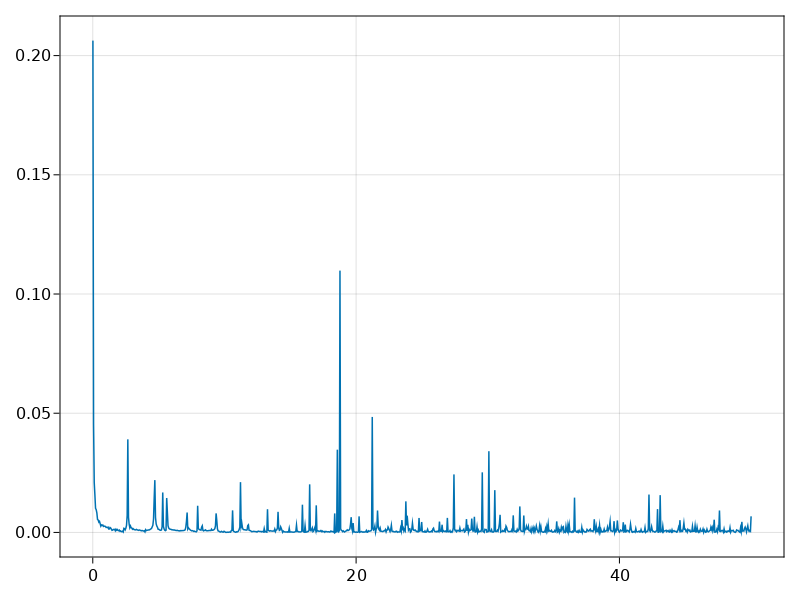

In [20]:
lines(ls, l_spec)

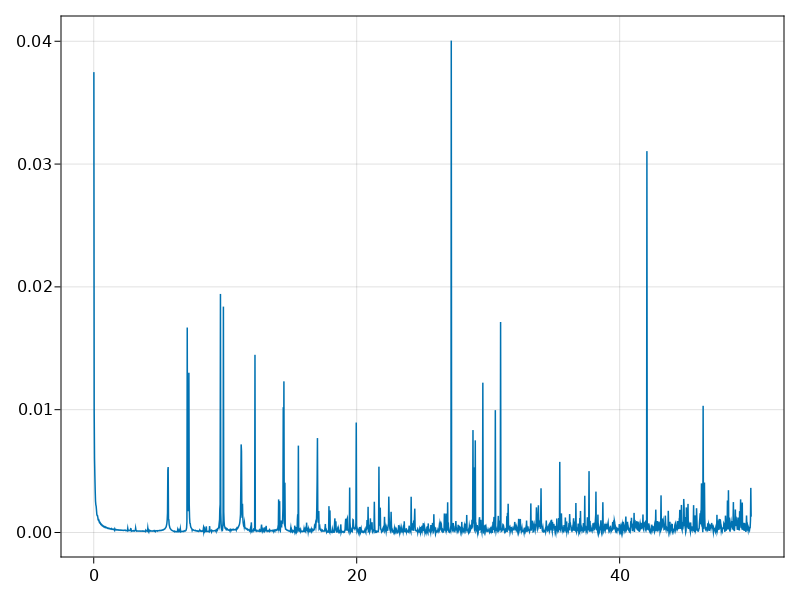

In [22]:
lines(ls, l_spec)